## Dataset Selection

In [2]:
import os
import pandas as pd

data_dir_path = r'data\elmundo_chunked_es_page1_40years'

documents = []

# Loop through all files in the directory
for filename in os.listdir(data_dir_path):
    if filename.endswith(".txt"):  # Only process .txt files
        file_path = os.path.join(data_dir_path, filename)
        
        # Open and read the text file
        with open(file_path, "r", encoding="utf-8") as file:
            text = file.read()
        
        # Store filename and text content
        documents.append({"filename": filename, "text": text})

# put in Pandas DataFrame
df = pd.DataFrame(documents)

## EDA

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dbigman\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1668 entries, 0 to 1667
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  1668 non-null   object
 1   text      1668 non-null   object
dtypes: object(2)
memory usage: 26.2+ KB


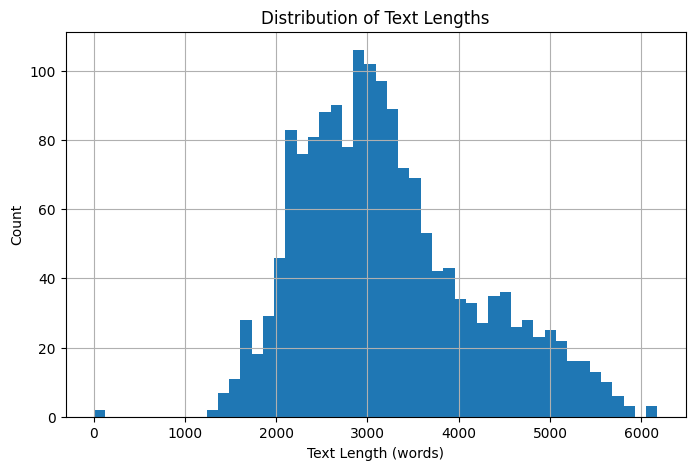

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from collections import Counter

nltk.download("punkt")

# Display basic information about the dataset
df_info = df.info()

# Add a column for text length (word count)
df["text_length"] = df["text"].apply(lambda x: len(str(x).split()))

# Summary statistics for text length
text_length_stats = df["text_length"].describe()

# Plot text length distribution
plt.figure(figsize=(8, 5))
df["text_length"].hist(bins=50)
plt.xlabel("Text Length (words)")
plt.ylabel("Count")
plt.title("Distribution of Text Lengths")
plt.show()

# Check for duplicate text entries
duplicate_count = df.duplicated(subset=["text"]).sum()
df = df.drop_duplicates(subset=["text"])

### Data cleaning, normalization and preprocessing

In [ ]:
import pandas as pd
import unidecode
import spacy
# import contractions
import string
import logging
import time
import re

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Start timer for execution tracking
start_time = time.time()
logging.info("Starting data preprocessing...")


# Ensure all text values are strings before applying unidecode
logging.info("Applying unidecode")
df['text'] = df['text'].astype(str).apply(unidecode.unidecode)

logging.info("Normalizing spaces")
df['text'] = df['text'].apply(lambda x: ' '.join(str(x).split()))  # Normalize spaces


# Loading NLP Model
# spacy_model = 'en_core_web_lg' # english
spacy_model = 'es_core_news_lg' # spanish
logging.info(f"Loading spacy model: {spacy_model}")
nlp = spacy.load(spacy_model)


# function to extract structured information (NER Engine)
def extract_structured_info(text):
    # Lowercase the text
    text = text.lower()
    
    # Remove punctuation but keep numbers
    text = re.sub(r'[^\w\s\d]', '', text)  # Keeps words, spaces, and numbers

    # Normalize spaces
    text = ' '.join(text.split())  

    # Process text with spaCy
    doc = nlp(text)

    # Dictionary to store structured data
    structured_data = {
        "Municipality": None,  # Now mapped to GPE
        "Landmark": None,      # Now mapped to FAC
        # "Restaurant": None,    # Not explicitly extracted (needs a custom rule)
        "Attraction": None,    # Mapped to LOC
        "Organization": None,  # ORG
        "Event": None,         # EVENT
        "Work_of_Art": None,   # WORK_OF_ART
        "Product": None        # PRODUCT
    }

    # Iterate over named entities
    for ent in doc.ents:
        if ent.label_ == "GPE":  # Geopolitical Entity (cities, states, countries)
            structured_data["Municipality"] = ent.text
        elif ent.label_ == "ORG":  # Organization
            structured_data["Organization"] = ent.text
        elif ent.label_ == "LOC":  # General Location
            structured_data["Attraction"] = ent.text
        elif ent.label_ == "FAC":  # Facilities (landmarks, buildings, bridges, airports)
            structured_data["Landmark"] = ent.text
        elif ent.label_ == "EVENT":  # Events (e.g., "World Cup", "Olympics")
            structured_data["Event"] = ent.text
        elif ent.label_ == "WORK_OF_ART":  # Books, songs, paintings, etc.
            structured_data["Work_of_Art"] = ent.text
        elif ent.label_ == "PRODUCT":  # Consumer products, devices, brands
            structured_data["Product"] = ent.text

    return structured_data
        


def preprocess_text(text):
    """Normalize text: expand contractions, lowercase, remove punctuation (except numbers), lemmatize"""
    # text = contractions.fix(text)  # Expand contractions
    text = text.lower()  # Lowercase
    # Remove punctuation but keep numbers
    text = text.translate(str.maketrans('', '', string.punctuation.replace('0123456789', '')))

    text = ' '.join(text.split())  # Normalize spaces
    
    doc = nlp(text)
       
    tokens = [token.lemma_ for token in doc]  # Lemmatization (without is_alpha)
    return ' '.join(tokens)






# Extract structured info
df["named_entities"] = df["text"].apply(extract_structured_info)


# Apply text preprocessing
df['normalized_text'] = df['text'].apply(preprocess_text)

# Log: Time taken
end_time = time.time()
logging.info(f"Total execution time: {end_time - start_time:.2f} seconds")


2025-02-11 01:00:08,477 - INFO - Starting data preprocessing...
2025-02-11 01:00:08,478 - INFO - Applying unidecode
2025-02-11 01:00:08,486 - INFO - Normalizing spaces
2025-02-11 01:00:08,790 - INFO - Loading spacy model: es_core_news_lg
2025-02-11 01:20:19,067 - INFO - Total execution time: 1210.59 seconds


In [11]:
import pandasai as pai
from dotenv import load_dotenv
import os

load_dotenv()
pai_api_key = os.getenv("PANDAS_AI_API_KEY")

if pai_api_key:
    pai.api_key.set(pai_api_key)



# Load your CSV file
file = pai.read_csv("df.csv")

# Save your dataset configuration
pai_df = pai.create(
  path="pai-personal-52ec7/travel_planner",
  df=file,
  description="el_mundo_dataset"
)

# Push your dataset to PandaBI
pai_df.push()

Dataset saved successfully to path: pai-personal-52ec7\travel_planner


PandaAIApiCallError: File data.parquet exceeds maximum size of 5.0 MB

### Visualization 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Ensure 'text_length' column exists
df["text_length"] = df["normalized_text"].apply(lambda x: len(x.split()))

# Text Length Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df["text_length"], bins=50, kde=True, color="blue")
plt.xlabel("Text Length (Words)")
plt.ylabel("Count")
plt.title("Distribution of Text Lengths")
plt.show()

# Most Common Words
all_words = " ".join(df["normalized_text"]).split()
word_freq = Counter(all_words)

# Get the 20 most common words
common_words = word_freq.most_common(20)
words, counts = zip(*common_words)

# Updated Bar Plot for Most Common Words
plt.figure(figsize=(10, 5))
sns.barplot(x=list(words), y=list(counts), hue=list(words), palette="viridis"
            # , legend=False
            )
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 20 Most Common Words in Dataset")
plt.xticks(rotation=45)
plt.show()


### Chunking

In [ ]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document

# Function to extract keywords using TF-IDF
def extract_keywords(text, top_n=5):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    tfidf_matrix = vectorizer.fit_transform([text])
    feature_names = vectorizer.get_feature_names_out()
    scores = tfidf_matrix.toarray().flatten()
    keyword_indices = scores.argsort()[-top_n:][::-1]  # Get top n keywords
    keywords = [feature_names[i] for i in keyword_indices]
    return ", ".join(keywords)

# Initialize text splitter with chunk size and overlap
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,     
    chunk_overlap=50
)

# Create a list of LangChain `Document` objects
chunks = []

for _, row in df.iterrows():
    # Split text into chunks using LangChain's splitter
    text_chunks = text_splitter.split_text(row["normalized_text"])
    keywords = extract_keywords(row["normalized_text"])  # Extract keywords from full text

    # Store each chunk as a `Document` object
    for chunk_id, chunk in enumerate(text_chunks):
        doc = Document(
            page_content=chunk, 
            metadata={
                "filename": row["filename"],
                "chunk_id": chunk_id,
                "keywords": keywords  # Store extracted keywords as metadata
            }
        )
        chunks.append(doc)

# Verify Output
print(f"Total Chunks: {len(chunks)}")
print(f"Example Chunk:\n{chunks[0].page_content}\n")
print(f"Metadata: {chunks[0].metadata}")


### Embedding

In [ ]:
import openai
from openai import OpenAI
from langchain_openai import OpenAIEmbeddings
from dotenv import load_dotenv
import os
from icecream import ic

load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

client = OpenAI()
embedding_model = OpenAIEmbeddings(model="text-embedding-3-large", openai_api_key=openai_api_key)

chunk_embeddings = [embedding_model.embed_query(doc.page_content) for doc in chunks]

# Verify embedding shape
print(f"Generated {len(chunk_embeddings)} embeddings")
print(f"Example Embedding (First Chunk): {chunk_embeddings[0][:5]}...")  # Display first 5 values

In [ ]:
import pickle

# Save embeddings and metadata
with open("embeddings.pkl", "wb") as f:
    pickle.dump({"embeddings": chunk_embeddings, "metadata": [doc.metadata for doc in chunks]}, f)

print("✅ Embeddings saved as embeddings.pkl!")


In [ ]:
from langchain.vectorstores import Chroma

# Initialize ChromaDB
persist_directory = "chroma_db"
vector_store = Chroma(persist_directory=persist_directory, embedding_function=embedding_model)

# Store documents with embeddings in Chroma
vector_store.add_documents(chunks)
vector_store.persist()

print("✅ Embeddings stored in ChromaDB!")


In [ ]:
# Validating that the embeddings capture semantic meaning by checking a few sample outputs.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import ast





print("Embedding Shape:", df["embedding"].iloc[0].shape)  # Should be (3072,) for 'text-embedding-3-large'

# Compute Similarities Between Sample Texts
sample_texts = df.sample(5)  # Select 5 random samples
embeddings = np.vstack(sample_texts["embedding"].values)  # Convert list of arrays to matrix

# Compute Cosine Similarity
cos_sim_matrix = cosine_similarity(embeddings)

# Print Pairwise Similarities
print("\n Pairwise Cosine Similarities Between Sample Texts:")
print(cos_sim_matrix)

# Visualize Embeddings with PCA 
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Scatter Plot of PCA-Reduced Embeddings
plt.figure(figsize=(6, 4))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], color="blue")

# Annotate with Sample File Names
for i, filename in enumerate(sample_texts["filename"]):
    plt.annotate(filename, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualization of Embeddings")
plt.show()


In [ ]:
#  Testing embeddings 

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Prepare Embeddings for Similarity Calculation
embeddings_matrix = np.vstack(df["embedding"].values)

# Compute Cosine Similarity Matrix
cos_sim_matrix = cosine_similarity(embeddings_matrix)

# Define a Function for Retrieval with a Similarity Threshold
def retrieve_similar_documents(query_embedding, df, threshold=0.75, top_n=5):
    """
    Retrieves documents from df based on cosine similarity to the query embedding.
    
    Args:
        query_embedding (np.array): The embedding of the query text.
        df (pd.DataFrame): The dataset containing document embeddings.
        threshold (float): Minimum cosine similarity required for retrieval.
        top_n (int): Maximum number of documents to return.

    Returns:
        pd.DataFrame: Filtered documents that meet the similarity threshold.
    """
    # Compute similarity between query and all document embeddings
    similarities = cosine_similarity([query_embedding], np.vstack(df["embedding"].values)).flatten()

    # Store results in a DataFrame
    df["similarity_score"] = similarities

    # Filter documents based on the threshold
    relevant_docs = df[df["similarity_score"] >= threshold]

    # Sort by highest similarity and return top_n results
    return relevant_docs.sort_values(by="similarity_score", ascending=False).head(top_n)

# Query Retrieval
query_text = "Puerto Rico economy coffee, tobacco, statehood, independence"
query_embedding = generate_openai_embedding(query_text)  # Generate embedding for the query

# Retrieve most relevant documents with different thresholds
strict_results = retrieve_similar_documents(query_embedding, df, threshold=0.40, top_n=5)
broad_results = retrieve_similar_documents(query_embedding, df, threshold=0.35, top_n=5)


print("\nStrict Retrieval (Threshold = 0.40)")
print(strict_results[["filename", "similarity_score"]])

print("\nBroad Retrieval (Threshold = 0.35)")
print(broad_results[["filename", "similarity_score"]])


In [ ]:
def retrieve_similar_documents(query_embedding, df, threshold=0.75, top_n=5):
    # Compute similarity between query and document embeddings
    similarities = cosine_similarity([query_embedding], np.vstack(df["embedding"].values)).flatten()
    
    # Store similarity scores in DataFrame
    df["similarity_score"] = similarities

    # Print similarity scores to debug
    print("\nAll Similarity Scores:")
    print(df[["filename", "similarity_score"]].sort_values(by="similarity_score", ascending=False).head(10))

    # Filter based on threshold
    relevant_docs = df[df["similarity_score"] >= threshold]
    
    # Sort and return top results
    return relevant_docs.sort_values(by="similarity_score", ascending=False).head(top_n)


query_text = "Japan war bomb"
query_embedding = generate_openai_embedding(query_text)  # Generate embedding for the query


strict_results = retrieve_similar_documents(query_embedding, df, threshold=0.40, top_n=5)
broad_results = retrieve_similar_documents(query_embedding, df, threshold=0.35, top_n=5)

# Print a document with the highest similarity
highest_sim_doc = df.iloc[787]["filename"]
print(f"\n Document with highest similarity: {highest_sim_doc}")

print("\nQuery: ", query_text)
